In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [47]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data['document'] = train_data['document'].astype(str)
test_data['document'] = test_data['document'].astype(str)

In [48]:
#변경 전
print('최초 샘플의 개수 :',len(train_data))

# 중복 제거
train_data.drop_duplicates(subset = ['document'], inplace=True) 

# 정규 표현식 수행
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

# 공백은 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
train_data = train_data.dropna(how='any')

#변경 후
print('전처리 후 샘플의 개수 :',len(train_data))

최초 샘플의 개수 : 150000
전처리 후 샘플의 개수 : 145791


In [49]:
#변경 전
print('최초 샘플의 개수 :',len(test_data))

# 중복 제거
test_data.drop_duplicates(subset = ['document'], inplace=True) 

# 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

# 공백은 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
test_data = test_data.dropna(how='any')

#변경 후
print('전처리 후 샘플의 개수 :',len(test_data))

최초 샘플의 개수 : 50000
전처리 후 샘플의 개수 : 48995


In [50]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [51]:
%%time 

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

Wall time: 6min 24s


In [52]:
%%time 

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

Wall time: 2min 2s


In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0   # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [54]:
vocab_size = total_cnt - rare_cnt + 2

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [55]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [56]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

In [57]:
print(len(X_train), len(y_train))

145380 145380


In [58]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [59]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [60]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 3.CNN(1D Convolutions)

In [61]:
X_train.shape, X_test.shape

((145380, 30), (48995, 30))

In [62]:
y_train[:145380].shape, y_test.shape

((145380,), (48995,))

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [64]:
embedding_dim = 256
batch_size = 256

In [65]:
model = Sequential()
model.add(Embedding(vocab_size, 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model_CNN.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         4970752   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [68]:
history = model.fit(X_train, y_train[:145380], epochs = 15, validation_data = (X_test, y_test), callbacks=[es, mc])

Train on 145380 samples, validate on 48995 samples
Epoch 1/15
145376/145380 [============================>.] - ETA: 0s - loss: 0.2890 - acc: 0.8785- ETA
Epoch 00001: val_acc improved from 0.84937 to 0.85445, saving model to best_model_CNN.h5
145380/145380 [==============================] - 654s 4ms/sample - loss: 0.2890 - acc: 0.8785 - val_loss: 0.3369 - val_acc: 0.8545
Epoch 2/15
145376/145380 [============================>.] - ETA: 0s - loss: 0.2247 - acc: 0.9094
Epoch 00002: val_acc did not improve from 0.85445
145380/145380 [==============================] - 730s 5ms/sample - loss: 0.2247 - acc: 0.9094 - val_loss: 0.3702 - val_acc: 0.8497
Epoch 3/15
145376/145380 [============================>.] - ETA: 0s - loss: 0.1698 - acc: 0.9333
Epoch 00003: val_acc did not improve from 0.85445
145380/145380 [==============================] - 685s 5ms/sample - loss: 0.1698 - acc: 0.9333 - val_loss: 0.4112 - val_acc: 0.8476
Epoch 4/15
145376/145380 [============================>.] - ETA: 0s - l

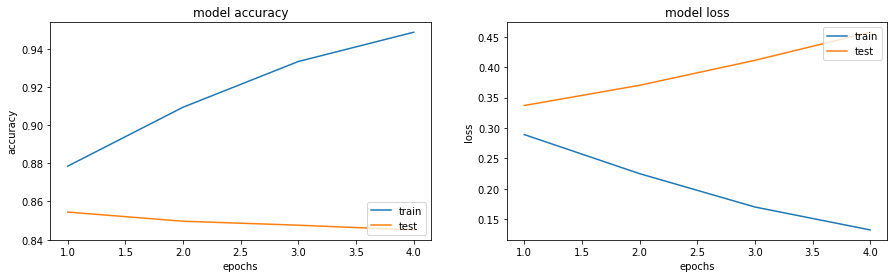

In [74]:
# 5. model evalustion : v1

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

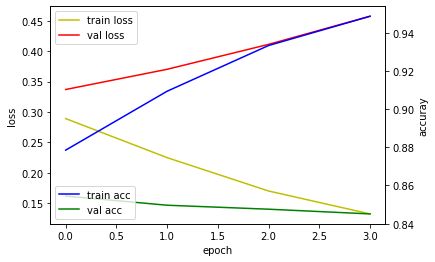

In [75]:
# 5. model evalustion : v2

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### Model select

In [78]:
loaded_model1 = load_model('best_model.h5')
loaded_model2 = load_model('best_model_CNN.h5')

In [91]:
def sentiment_predict1(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model1.predict(pad_new)) # 예측
    if(score > 0.5):
        print(" + RNN 모형 기준, {:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print(" + RNN 모형 기준, {:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [92]:
def sentiment_predict2(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model2.predict(pad_new)) # 예측
    if(score > 0.5):
        print(" + CNN 모형 기준, {:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print(" + CNN 모형 기준, {:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [93]:
print('Text : {}'.format('저렴하게 잘 샀어요.\n'))
sentiment_predict1('저렴하게 잘 샀어요')
sentiment_predict2('저렴하게 잘 샀어요')

Text : 저렴하게 잘 샀어요.

 + RNN 모형 기준, 85.41% 확률로 부정 리뷰입니다.

 + CNN 모형 기준, 89.93% 확률로 부정 리뷰입니다.



In [88]:
text = '폴바셋 라떼와 아이스크림은 사랑입니다♡♡♡ 티몬 최고!! 매일두 앱은 이번에 처음 알게되서 깔았는데 혜택이 많네요! 감사합니다.'
print('Text : {} \n'.format(text))
sentiment_predict1(text)
sentiment_predict2(text)

Text : 폴바셋 라떼와 아이스크림은 사랑입니다♡♡♡ 티몬 최고!! 매일두 앱은 이번에 처음 알게되서 깔았는데 혜택이 많네요! 감사합니다. 

RNN 모델 기준, 94.96% 확률로 긍정 리뷰입니다.

CNN 모델 기준, 94.39% 확률로 긍정 리뷰입니다.



In [89]:
text = '폴바셋첨가봤는데 최고네요 서비스가 국내최고급인듯 호텔고급카페에온기분'
print('Text : {} \n'.format(text))
sentiment_predict1(text)
sentiment_predict2(text)

Text : 폴바셋첨가봤는데 최고네요 서비스가 국내최고급인듯 호텔고급카페에온기분 

RNN 모델 기준, 56.44% 확률로 부정 리뷰입니다.

CNN 모델 기준, 98.10% 확률로 긍정 리뷰입니다.

